# Class SR fit across multiple model at same age

In [1]:
# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering
import torch
import pandas as pd
import random
from sklearn.metrics import r2_score

# Internal code import
import physo
import physo.learn.monitoring as monitoring
from physo.benchmark.utils import symbolic_utils as su
import sympy
from sympy import lambdify
import copy

Enforcing spawn multiprocessing start method.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.

Multiprocessing start method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs available :  96
Recommended config {'parallel_mode': False, 'n_cpus': 96}
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start metho

/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/reward.py:252: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [2]:
DATA_PATH = '../Nbody/'

In [3]:
def list_folders(path):
    # List all entries in the directory given by path
    entries = os.listdir(path)
    # Filter out only directories
    folders = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
    return [s for s in folders if '_' in s]

In [4]:
def load_data(model_name, myvars, simrange='mass_0.0-0.5', simtype='mass'):
    data = {}
    for name, filetag in myvars.items():
        data[name] = pd.read_csv(DATA_PATH + model_name + "/{}/{}_{}.dat".format(simtype,simrange,filetag), \
                                 delimiter=" ", header=None).to_numpy()
    data['age'] = pd.read_csv(DATA_PATH + model_name + "/age.dat", sep=r"\s+", header=None).to_numpy().flatten()
    
    return data

In [5]:
def select_slice(data, ref_age):
    idx = np.argmin(np.abs(data['age']-ref_age))
    myslice = copy.copy(data)
    for name in set(data.keys()) - set(['age']):
        myslice[name] = data[name][idx,:]
    myslice['age'] = ref_age
    return myslice

In [6]:
def dropna(data):
    selected_idx = ~np.isnan(data['mass'])
    for name in set(data.keys()) - set(['age']):
        data[name] = data[name][selected_idx]
    return data

In [7]:
def reduce(data, ref_var='mass', factor=100):
    selected_idx = range(0, len(data[ref_var]), factor)
    reduced = copy.copy(data)
    reduced['age'] = np.concatenate([np.full_like(data[ref_var][idx], data['age'][idx]) for idx in selected_idx])
    for name in set(data.keys()) - set(['age']):
        reduced[name] = data[name][selected_idx]
    return reduced

In [8]:
def target_vars(variables, ref_vars=['mass', 'age']):
    return list(set(variables)-set(ref_vars))

In [9]:
models = list_folders(DATA_PATH)
print(models)

['250k_A_R2_10', '250k_A_R4_25_imf50', '250k_A_R4_25_retr', '250k_A_R4_25_lk', '250k_A_R2_25_vlk', '500k_C_R4_10', '250k_C_R2_10', '250k_C_R4_25', '250k_A_R4_25', '500k_A_R4_LC_part2', '250k_B_R4_25', '250k_C_R4_25_lk', '1.5M_A_R4_10', '250k_B_R4_25_lk', '250k_A_R2_25', '250k_C_R4_10', '250k_A_R2_5', '250k_A_R4_10', '250k_W6_R4_25_retr', '250k_W6_R4_25', '500k_A_R2_10', '250k_A_R4_10_retr', '250k_A_R4_25_vlk', '500k_A_R4_10', '500k_A_R4_LC_part1']


In [10]:
variables = {'mass': 'mass_bin', 'velocity': 'vphi', 'dispersion': 'disp_phi', 'radius': 'radial_bin'}
labels = {'mass': r"$mass$ [M\_\odot]", 'velocity': r"$v_\phi$ [km/s]", 'dispersion': r"$\sigma_\phi$ [km/s]", 'radius': 'r [km]'}

## Take a slice at given age across multiple models

In [11]:
ref_age = 10000 # Myr

data = {}
for model in models:
    full_dataset = load_data(model, variables)
    data[model] = dropna(select_slice(full_dataset, ref_age))

## Store in multi X and y arrays

In [12]:
def remove_outliers(data, threshold=2, var='mass'):
    trimmed_data = {}
    for model, res in data.items(): 
        selected_idx = res[var] < threshold
        for name in set(res.keys()) - set(['age']):
            res[name] = res[name][selected_idx]
        trimmed_data[model] = res
    return trimmed_data

Text(0, 0.5, '$\\sigma_\\phi$ [km/s]')

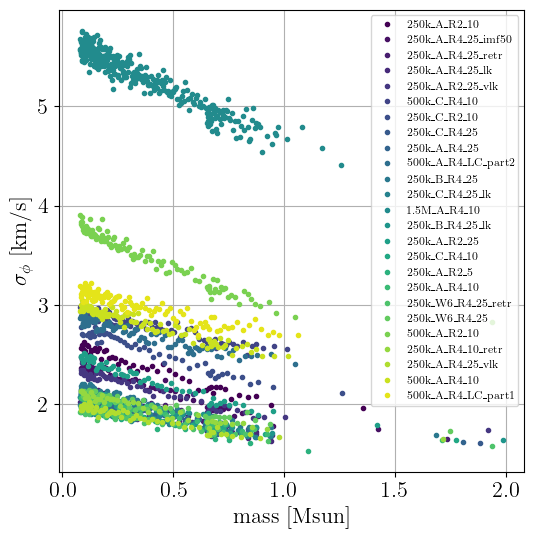

In [13]:
data = remove_outliers(data)

multiX = [np.reshape(d['mass'], (1, -1)) for d in data.values()]
multiy = [d['dispersion'] for d in data.values()]
# print(len(multiX), len(multiX[0]))

fig, ax = plt.subplots(1, figsize=(6,6))
cmap = plt.get_cmap('viridis')
for n, (m, d, label) in enumerate(zip(multiX,multiy,data.keys())):
    color = cmap(n / len(multiX))
    ax.plot(m.flatten(), d.flatten(), '.', color=color,label=label)
ax.legend(fontsize=8)
ax.grid("on")
ax.set_xlabel("mass [Msun]")
ax.set_ylabel(labels['dispersion'])

# Linear fit

In [14]:
slopes = []
intercepts = []
linfit_scores = []
for m, d in zip(multiX,multiy):
    m = m.flatten()
    d = d.flatten()
    slope, intercept = np.polyfit(m, d, 1)
    linfit_scores.append(r2_score(d, slope*m+intercept))
    slopes.append(slope)  
    intercepts.append(intercept)

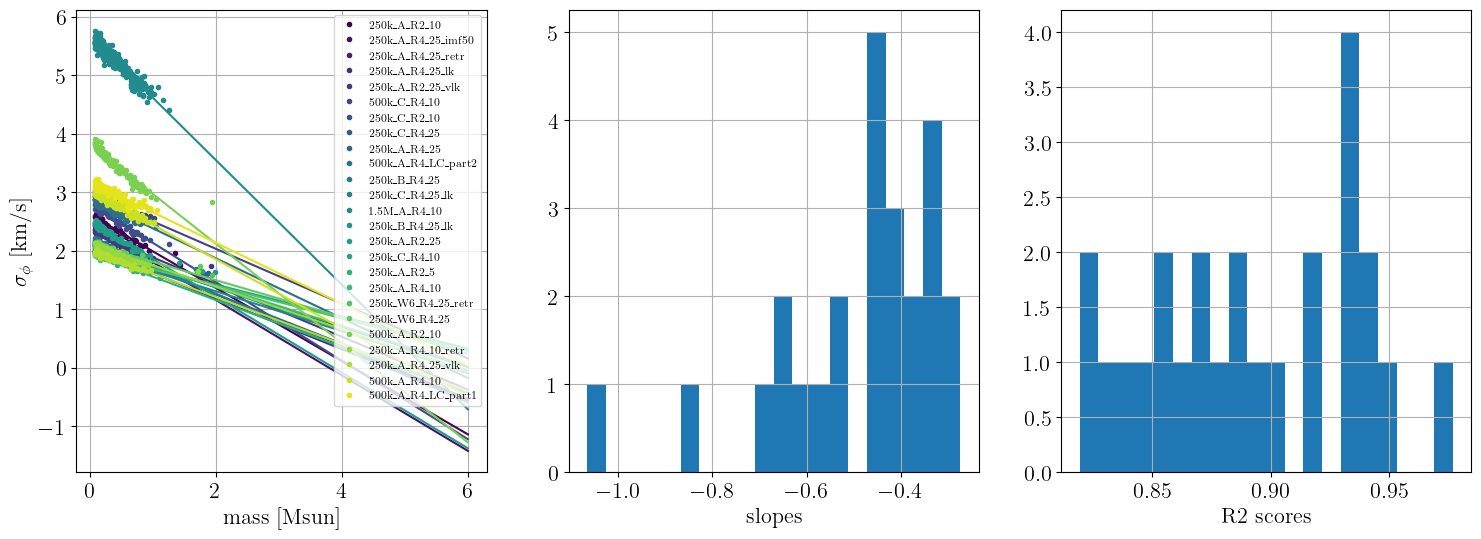

In [15]:
m_axis = np.linspace(start=0.1, stop=6, num=1000)

fig, ax = plt.subplots(1,3, figsize=(18,6))
cmap = plt.get_cmap('viridis')
for n, (m, d, label,a, b) in enumerate(zip(multiX,multiy,data.keys(),slopes,intercepts)):
    color = cmap(n / len(multiX))
    ax[0].plot(m.flatten(), d.flatten(), '.', color=color,label=label)
    ax[0].plot(m_axis, a*m_axis+b,'-',color=color)
ax[0].legend(fontsize=8)
ax[0].grid("on")
ax[0].set_xlabel("mass [Msun]")
ax[0].set_ylabel(labels['dispersion'])
#ax[1].hist(exponents,bins=20)
ax[1].hist(slopes,bins=20)
ax[1].grid("on")
ax[1].set_xlabel("slopes")
ax[2].hist(linfit_scores,bins=20)
ax[2].set_xlabel("R2 scores")
ax[2].grid("on")

## Power law

In [17]:
factors = []
exponents = []
powfit_scores = []
for m, d in zip(multiX,multiy):
    m = m.flatten()
    d = d.flatten()
    slope, intercept = np.polyfit(np.log(m.flatten()), np.log(d.flatten()), 1)
    a = np.exp(intercept)  # Pre-factor
    b = slope              # Exponent
    powfit_scores.append(r2_score(d, a * m**b))
    factors.append(a)
    exponents.append(b)      

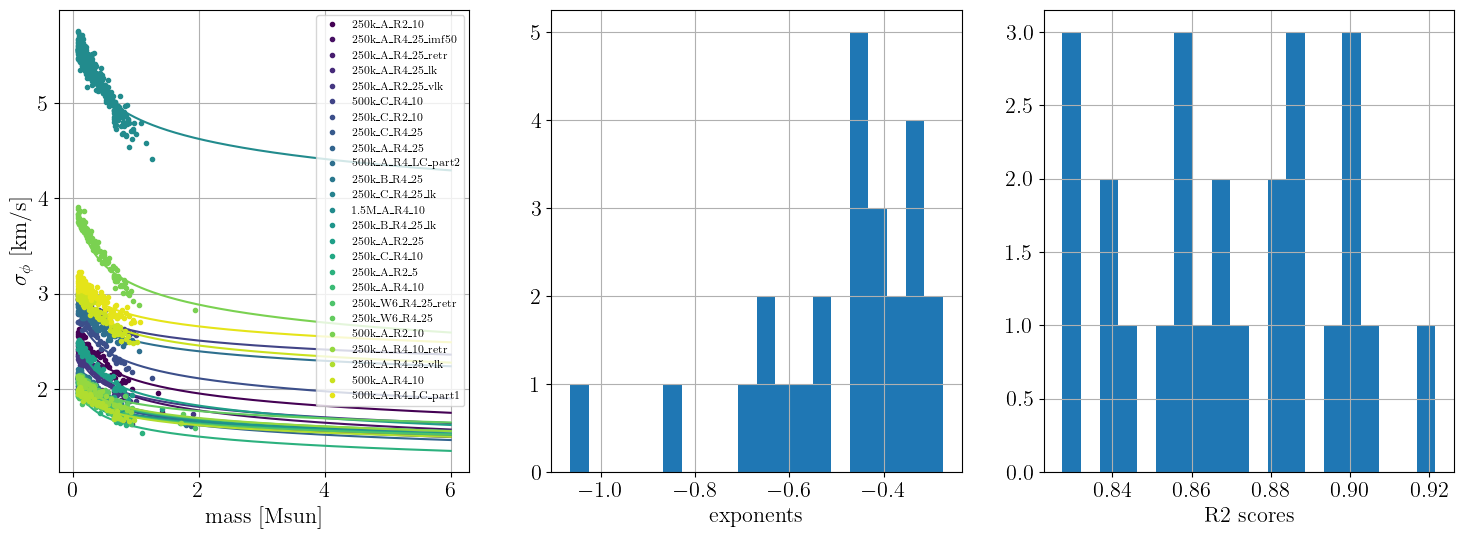

In [20]:
m_axis = np.linspace(start=0.1, stop=6, num=1000)

fig, ax = plt.subplots(1,3, figsize=(18,6))
cmap = plt.get_cmap('viridis')
for n, (m, d, label, a, b) in enumerate(zip(multiX,multiy,data.keys(),factors,exponents)):
    color = cmap(n / len(multiX))
    ax[0].plot(m.flatten(), d.flatten(), '.', color=color,label=label)
    ax[0].plot(m_axis, a * m_axis**b,'-',color=color)
ax[0].legend(fontsize=8)
ax[0].grid("on")
ax[0].set_xlabel("mass [Msun]")
ax[0].set_ylabel(labels['dispersion'])
#ax[1].hist(exponents,bins=20)
ax[1].hist(slopes,bins=20)
ax[1].grid("on")
ax[1].set_xlabel("exponents")
ax[2].hist(powfit_scores,bins=20)
ax[2].set_xlabel("R2 scores")
ax[2].grid("on")